- 이 글에서는 Amazon Aurora가 쿼럼 구성을 관리하면서 생길 수 있는 문제를 어떻게 피하는지를 설명

**쿼럼 구성원 관리 방법**


- 하드웨어 시스템은 장애가 발생할 수 있음.
  - 쿼럼 구성원 중 하나에 장애가 발생하면, 새로운 노드를 생성하여 해당 쿼럼을 구성원을 복구 할 수 있음.
  - 이러한 문제 해결 방법은 복잡한 상황을 만들 수 있음.
  - 정상인 쿼럼 구성원은 문제가 생긴 쿼럼이 어떠한 상황인지 판단하기 어려움.
  - 문제가 생긴 쿼럼 구성원은 지연 시간이 증가하거나, 일시적 지연이 있는 상태이거나 재가동이 일어나거나, 아니면 완전히 장애 생태일 수도 있음.
  - 이 때, 네트워크 파티션을 통해 여러 쿼럼 구성원 모임이 서로를 분리할 수 있음.

- 노드마다 지속적으로 보존해야 하는 상태 정보가 많은 경우, 쿼럼을 복구하기 위해 상태 정보를 재복제(re-replication)하는 데는 시간이 오래 걸릴 수 있음.
  - 이런 경우 문제가 생긴 노드가 다시 정상으로 복구 될 수도 있기 때문에 보다 보수적으로 복구 구성을 진행.
  - 또는 복구 시간을 줄이기 위해 상태 정보를 여러 구역으로 분리하여 저장하도록 최적화를 할 수 있음.
  - 여전히 장애가 발생할 수 있는 가능성은 증가.

- Amazon Aurora는 3의 가용 영역(AZ)에 총 6개의 복제본을 구성하며, 10GB의 청크(Chunk)로 데이터베이스 볼륨을 구성.
  - 현재 최대 데이터베이스 크기는 64 TB이며, 이는 6,400의 보호 그룹과 38,400 의 세그먼트로 구분해 볼 수 있음.
  - 이렇게 큰 규모에서는 이슈는 어디서든 발생할 수 있음.
  - 쿼럼 멤버구성의 변화를 관리하는 일반적인 방법은 일정 시간을 보류하는 방법과 Paxos와 같은 동기화 프로토콜을 사용.
  - 하지만 Paxos는 무거운 프로토콜이며, 최적화된 버전도 다중 장애에서는 지연이 발생.



**쿼럼 집합을 통한 장애 관리**


- Aurora는 쿼럼 집합이라는 개념과 로깅, 롤백, 그리고 쿼럼 구성원의 변화를 관리하는 것을 사용
  - 예를 들어 A, B, C, D, E, F와 같이 6개의 세그먼트가 하나의 독립적인 보호 그룹에 속한다고 가정하면, 쓰기 쿼럼은 6개 중 무작위로 선택한 4개의 세그먼트에 해당
  - 그리고, 읽기 쿼럼은 6개 중 무작위로 선택한 3개의 세그먼트
  - 이전 글에서 설명한 것처럼, Aurora 쿼럼은 이보다 훨씬 복잡하지만, 위와 같은 간단한 설명 방식을 통해 간단하게 이해가능.

- Aurora는 읽기 쓰기를 할 때 구성원 시점(epoch) 개념을 사용
  - 각 구성원의 변화가 있으면 특정 값이 독립적으로 증가
  - 이는 읽기와 쓰기를 수행할 경우, 만약 이전 시점의 값이면 수행이 거부
  - 이 경우 읽기나 쓰기 요청을 한 호출자는 쿼럼 구성원에 대한 정보를 새롭게 갱신해야만 함
  - 이것은 실행 로그에서 사용되는 로그시퀀스번호(LSN)의 개념과 유사
  - 시점 값과 그에 해당하는 변경 레코드는 구성원 변화을 순서대로 제공
  - 구성원 시점의 변화는 쓰기가 이뤄졌을 경우 쓰기 쿼럼을 만족해야 하며, 읽기가 이뤄졌을 경우는 현재 읽기 쿼럼을 만족해야만 함



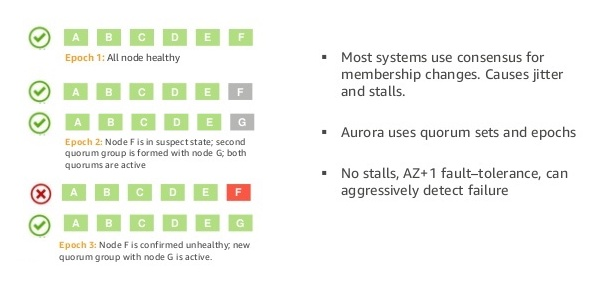

- 위에서 예를 든 보호 그룹의 경우, 만약 F 세그먼트가 장애가 있다고 가정한다면, 새로운 G 세그먼트를 생성.
  - 아직 F 세그먼트를 제외시키지는 않음.
  - 그 이유는 아주 일시적인 장애여서 빠르게 정상화 될 수도 있기 때
  - 아니면 요청을 처리 중이지만 잠시 문제가 된 것처럼 보일 수도 있음
  - 하지만, Aurora는 F 세그먼트가 다시 정상화 되었는지 기다리지는 않음
  - 왜냐하면 어떤 쿼럼이 문제가 생겼는지 보는데 시간이 추가되며, 또 다른 장애가 생길 수도 있기 때문

- Aurora는 이 문제를 해결하기 위해 쿼럼 집합 개념을 사용
  - Aurora는 ABCDEF에서 ABCDEG로 바로 구성원 정보를 변경하지 않음
  - 대신, Aurora는 구성원 시점을 적용하여, 쿼럼 집합을 ‘ABCDEF AND ABCDEG’로 설정
  - 쓰기가 일어났을 경우, Aurora는 6개 중 4개의 복제본에서 ABCDEF을 응답을 받고 또한 6개 중 4개의 복제본에서 ABCDEG의 응답도 받음
  - 4개 중 어떠한 복제본의 응답에서든 ABCDE의 대해서는 쓰기 쿼럼을 만족.
  - 읽기나 복구 쿼럼은 동일하게 작동하며, ABCDEF와 ABCDEG에서 부터 각각 어떤 세 개의 응답에 대해서 만족하면, 두 경우 ABCDE에 대해서도 만족.

- 데이터가 모두 G 세그먼트에 적제를 완료하면, 이제 Aurora는 F 세그먼트를 빼기로 결정
  - 그룹원 시점에 대한 변경을 진행하며, ABCDEG로 구성원 시점과 쿼럼 집합을 ABCDEG로 변경
  - 이러한 변경은 유일하게 실행되며, 이는 실행 로그 처리에서 LSN 값을 수행하는 것과 유사
  - 이러한 시점 값의 변경은 현재의 쓰기 쿼럼을 만족시켜야만 함
  - 이는 ABCDEF에 대한 6개 중 4개의 응답과 ABCDEG에 대해서도 6개 중 4개의 응답이 필요
  - 만약 G에 모든 적제가 끝나기 전에 F가 다시 돌아온다면, Aurora는 구성원 시점을 변경하여 쉽게 ABCDEF로 롤백할 수 있음
  - Aurora는 모든 쿼럼 상태가 정상으로 돌아올 때 가지 어떠한 상태 정보나 세그먼트를 삭제하지 않음.
  -

- 쿼럼에 읽고 쓰기는 변경 전후와 마찬가지로 구성원 변경 때 이루어짐.
  - 쿼럼 구성원 변경은 읽기 쓰기 작업을 막지 않음.
  - 오히려 최대한 요청자에게 기존 쿼럼 정보를 업데이트 할 수 있도록하여 정확한 쿼럼 정보를 얻게 됨.
  - 쿼럼 구성원 변경은 읽기 쓰기에 기다리게하지(non-blocking) 않고 수행.

- 물론 G 세그먼트에 데이터를 모두 적제하여 복구하는 과정에서 ABCDEG 역시 문제가 생길 수 있음.
  - 많은 구성원 변경 프로토콜은 구성원 변경 중에 생기는 장애를 빠르게 대응하기 어려움.
  - 하지만 쿼럼 집합과 시점 개념은 매우 쉽게 해결 할 수 있음.
  - 만약 E 세그먼트 역시 장애가 있다고 가정할 경우, H 세그먼트로 대치.
  - Aurora는 이러한 경우 단지 쿼럽을 ABCDEF AND ABCDEG AND ABCDFH AND ABCDGH로 변경.
  - 단일 장애 순간에도 ABCD에 대해 쓰기 작업은 쿼럼을 만족하여 쓸 수 있음.
  - 이러한 구성원 변화는 읽기 쓰기 모두 동일한 내결함성 수준을 가짐.

구성원 변경 관리에 대해서 쿼럼 집합을 이용하는 것은 Aurora 서비스가 작은 크기의 세그먼트를 활용할 수 있게 합니다.
- 이것은 평균 복구 시간 (Mean Time To Repair; MTTR)과 여러 장애가 발생했을 때 피해를 줄여 Aurora의 장애에 대한 내구성을 높힙니다.
- 이것은 또한 고객의 비용을 줄여줍니다.
- Aurora의 볼륨은 자동으로 필요할 때 늘어나며, 작은 세그먼트는 적절한 크기만큼만 증가하도록 돕습니다.
- 쿼럼 집합을 사용하는 것은 읽기 쓰기 작업이 구성원의 변화 중에도 지속적으로 작업을 할 수 있도록 합니다.
-

구성원의 변화에 대한 결정을 복구할 수 있도록 만든 것은 Aurora가 쿼럼의 변화를 쉽게 할 수 있습니다.
- - 이것은 장애로 판단된 부분이 바로 돌아오면 언제든 원래로 되돌릴 수 있게합니다.
- 몇몇 다른 시스템들은 쿼럼 구성원과 재접속을 해야하고 쿼럼 정보를 바로 업데이트 하지 못 해 지연이 발생하기도 합니다.
- Aurora는 구성원 변경에 따른 지연에 따른 내구성의 문제가 발생하지도 앟으며, 읽기, 쓰기, 또는 쿼럼 구성원 접근과 업데이트에 따른 지연이 발생하지 않습니다.
-

Aurora는 여러 가지 측면에서 보다 앞선 기술을 제공합니다.
- - 데이터베이스와 분산 시스템의 구성을 연계한 우리의 접근 방법은 이러한 앞선 기술을 제공하는 핵심입니다.
- 지금까지 Aurora가 쿼럼을 어떻게 사용하여 문제점들을 피할 수 있는지 알아보았으며, 여러분의 애플리케이션이나 시스템을 디자인하는 데 도움이 되길 희망합니다.
- 다양한 요소들이 전제되어 있긴 하지만 Aurora가 사용한 기술은 다양한 부분에 충분히 적용할 수 있습니다.
-